# Circuit

> SAX Circuits

Let's start where we left off (see [Netlist](06_netlist.ipynb)).

In [2]:
import os
import warnings

try:
    from jax import jit
except ImportError:
    jit = lambda x: x

os.environ["LOGURU_LEVEL"] = "CRITICAL"
warnings.filterwarnings("ignore")

In [3]:
from __future__ import annotations

import os
import shutil
import sys
from functools import partial
from typing import Any, Dict, List, NamedTuple, Optional, Tuple, TypedDict, Union

import black
import networkx as nx
import numpy as np
from sax import reciprocal
from sax.backends import circuit_backends
from sax.multimode import multimode, singlemode
from sax.netlist import Netlist, RecursiveNetlist
from sax.netlist_cleaning import remove_unused_instances
from sax.typing_ import Model, Settings, SType, sdict, sdense, scoo
from sax.utils import (
    _replace_kwargs,
    get_ports,
    get_settings,
    merge_dicts,
    update_settings,
)

In [4]:
try:
    from pydantic.v1 import ValidationError
except ImportError:
    from pydantic import ValidationError

Let's start by creating a simple recursive netlist with gdsfactory.

:::{note}
We are using gdsfactory to create our netlist because it allows us to see the circuit we want to simulate and because we're striving to have a compatible netlist implementation in SAX.

However... gdsfactory is not a dependency of SAX. You can also define your circuits by hand (see [SAX Quick Start](../examples/01_quick_start.ipynb) or you can use another tool to programmatically construct your netlists.
:::

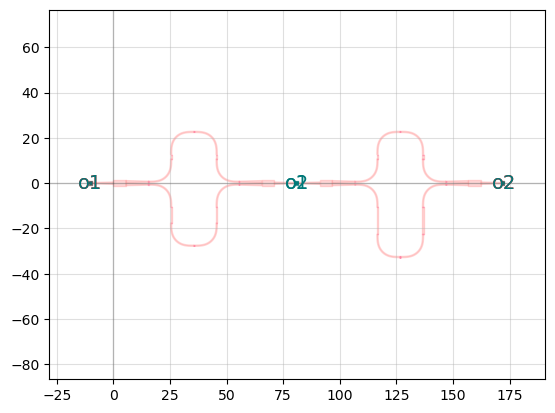

In [5]:
import gdsfactory as gf
from IPython.display import display
from gdsfactory.components import mzi
from gdsfactory.get_netlist import get_netlist_recursive, get_netlist, get_netlist_yaml
from gdsfactory.quickplotter import quickplot


@gf.cell
def twomzi():
    c = gf.Component()

    # instances
    mzi1 = mzi(delta_length=10)
    mzi2 = mzi(delta_length=20)

    # references
    mzi1_ = c << mzi1
    mzi2_ = c << mzi2

    # connections
    mzi2_.connect("o1", mzi1_.ports["o2"])

    # ports
    c.add_port("o1", port=mzi1_.ports["o1"])
    c.add_port("o2", port=mzi2_.ports["o2"])
    return c


comp = twomzi()
quickplot(comp)
recnet = RecursiveNetlist.parse_obj(
    get_netlist_recursive(
        comp, get_netlist_func=partial(get_netlist, full_settings=True)
    )
)
flatnet = recnet.__root__["mzi_delta_length10"]

To be able to model this device we'll need some SAX dummy models:

In [6]:
def bend_euler(
    angle=90.0,
    p=0.5,
    # cross_section="strip",
    # direction="ccw",
    # with_bbox=True,
    # with_arc_floorplan=True,
    # npoints=720,
):
    return reciprocal({
        ('o1', 'o2'): 1.0
    })

In [7]:
def mmi1x2(
    width=0.5,
    width_taper= 1.0,
    length_taper= 10.0,
    length_mmi= 5.5,
    width_mmi= 2.5,
    gap_mmi= 0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return reciprocal({
        ('o1', 'o2'): 0.45**0.5,
        ('o1', 'o3'): 0.45**0.5,
    })

In [8]:
def mmi2x2(
    width=0.5,
    width_taper= 1.0,
    length_taper= 10.0,
    length_mmi= 5.5,
    width_mmi= 2.5,
    gap_mmi= 0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return reciprocal({
        ('o1', 'o3'): 0.45**0.5,
        ('o1', 'o4'): 1j * 0.45**0.5,
        ('o2', 'o3'): 1j * 0.45**0.5,
        ('o2', 'o4'): 0.45**0.5,
    })

In [9]:
def straight(
    length=0.01,
    #npoints=2,
    #with_bbox=True,
    #cross_section=...
):
    return reciprocal({
        ('o1', 'o2'): 1.0
    })

In SAX, we usually aggregate the available models in a models dictionary:

In [10]:
models = {
    'straight': straight,
    'bend_euler': bend_euler,
    'mmi1x2': mmi1x2,
}

We can also create some dummy multimode models:

In [11]:
def bend_euler_mm(
    angle=90.0,
    p=0.5,
    # cross_section="strip",
    # direction="ccw",
    # with_bbox=True,
    # with_arc_floorplan=True,
    # npoints=720,
):
    return reciprocal({
        ('o1@TE', 'o2@TE'): 0.9**0.5,
        #('o1@TE', 'o2@TM'): 0.01**0.5,
        #('o1@TM', 'o2@TE'): 0.01**0.5,
        ('o1@TM', 'o2@TM'): 0.8**0.5,
    })

In [12]:
def mmi1x2_mm(
    width=0.5,
    width_taper= 1.0,
    length_taper= 10.0,
    length_mmi= 5.5,
    width_mmi= 2.5,
    gap_mmi= 0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return reciprocal({
        ('o1@TE', 'o2@TE'): 0.45**0.5,
        ('o1@TE', 'o3@TE'): 0.45**0.5,
        ('o1@TM', 'o2@TM'): 0.41**0.5,
        ('o1@TM', 'o3@TM'): 0.41**0.5,
        ('o1@TE', 'o2@TM'): 0.01**0.5,
        ('o1@TM', 'o2@TE'): 0.01**0.5,
        ('o1@TE', 'o3@TM'): 0.02**0.5,
        ('o1@TM', 'o3@TE'): 0.02**0.5,
    })

In [13]:
def straight_mm(
    length=0.01,
    #npoints=2,
    #with_bbox=True,
    #cross_section=...
):
    return reciprocal({
        ('o1@TE', 'o2@TE'): 1.0,
        ('o1@TM', 'o2@TM'): 1.0,
    })

In [14]:
models_mm = {
    'straight': straight_mm,
    'bend_euler': bend_euler_mm,
    'mmi1x2': mmi1x2_mm,
}

We can now represent our recursive netlist model as a Directed Acyclic Graph:

:::{eval-rst}
.. autofunction:: sax.circuit.create_dag
:::


In [15]:
def create_dag(
    netlist: RecursiveNetlist,
    models: Optional[Dict[str, Any]] = None,
):
    if models is None:
        models = {}
    assert isinstance(models, dict)

    all_models = {}
    g = nx.DiGraph()

    for model_name, subnetlist in netlist.dict()["__root__"].items():
        if not model_name in all_models:
            all_models[model_name] = models.get(model_name, subnetlist)
            g.add_node(model_name)
        if model_name in models:
            continue
        for instance in subnetlist["instances"].values():
            component = instance["component"]
            if not component in all_models:
                all_models[component] = models.get(component, None)
                g.add_node(component)
            g.add_edge(model_name, component)

    # we only need the nodes that depend on the parent...
    parent_node = next(iter(netlist.__root__.keys()))
    nodes = [parent_node, *nx.descendants(g, parent_node)]
    g = nx.induced_subgraph(g, nodes)

    return g

:::{eval-rst}
.. autofunction:: sax.circuit.draw_dag
:::


In [16]:
def draw_dag(dag, with_labels=True, **kwargs):
    _patch_path()
    if shutil.which("dot"):
        return nx.draw(
            dag,
            nx.nx_pydot.pydot_layout(dag, prog="dot"),
            with_labels=with_labels,
            **kwargs
        )
    else:
        return nx.draw(dag, _my_dag_pos(dag), with_labels=with_labels, **kwargs)


def _patch_path():
    os_paths = {p: None for p in os.environ.get("PATH", "").split(os.pathsep)}
    sys_paths = {p: None for p in sys.path}
    other_paths = {os.path.dirname(sys.executable): None}
    os.environ["PATH"] = os.pathsep.join({**os_paths, **sys_paths, **other_paths})


def _my_dag_pos(dag):
    # inferior to pydot
    in_degree = {}
    for k, v in dag.in_degree():
        if v not in in_degree:
            in_degree[v] = []
        in_degree[v].append(k)

    widths = {k: len(vs) for k, vs in in_degree.items()}
    width = max(widths.values())
    height = max(widths) + 1

    horizontal_pos = {
        k: np.linspace(0, 1, w + 2)[1:-1] * width for k, w in widths.items()
    }

    pos = {}
    for k, vs in in_degree.items():
        for x, v in zip(horizontal_pos[k], vs):
            pos[v] = (x, -k)
    return pos

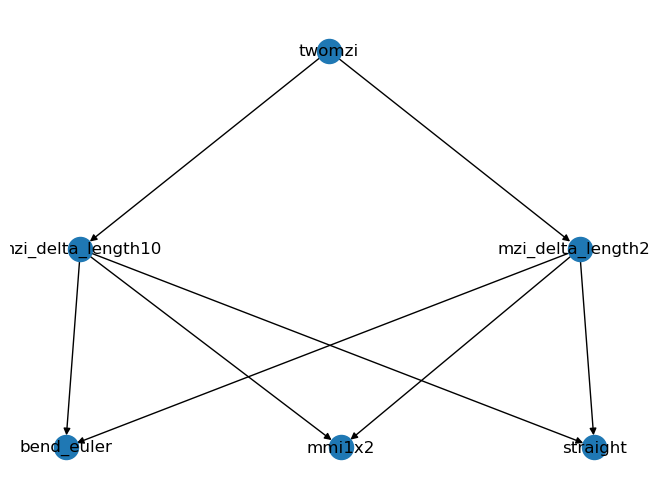

In [17]:
dag = create_dag(recnet, models)
draw_dag(dag)

Note that the DAG depends on the models we supply. We could for example stub one of the sub-netlists by a pre-defined model:

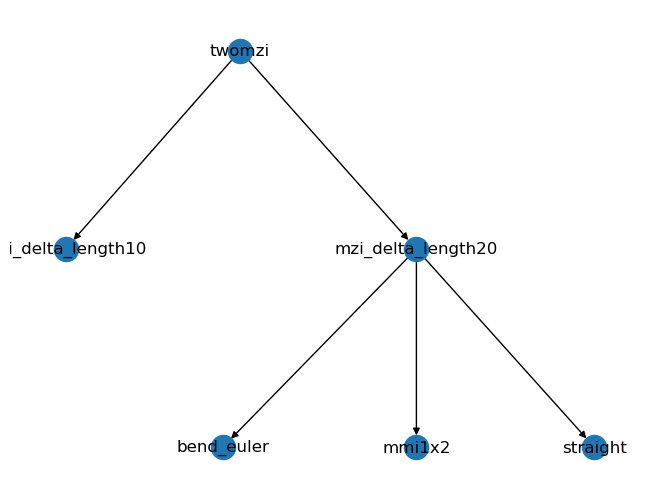

In [18]:
dag_ = create_dag(recnet, {**models, 'mzi_delta_length10': mmi2x2})
draw_dag(dag_, with_labels=True)

This is useful if we for example pre-calculated a certain model.

We can easily find the root of the DAG:

:::{eval-rst}
.. autofunction:: sax.circuit.find_root
:::


In [19]:
def find_root(g):
    nodes = [n for n, d in g.in_degree() if d == 0]
    return nodes

In [20]:
find_root(dag)

['twomzi']

Similarly we can find the leaves:

:::{eval-rst}
.. autofunction:: sax.circuit.find_leaves
:::


In [21]:
def find_leaves(g):
    nodes = [n for n, d in g.out_degree() if d == 0]
    return nodes

In [22]:
find_leaves(dag)

['bend_euler', 'mmi1x2', 'straight']

To be able to simulate the circuit, we need to supply a model for each of the leaves in the dependency DAG. Let's write a validator that checks this

In [23]:
def _validate_models(models, dag):
    required_models = find_leaves(dag)
    missing_models = [m for m in required_models if m not in models]
    if missing_models:
        model_diff = {
            "Missing Models": missing_models,
            "Given Models": list(models),
            "Required Models": required_models,
        }
        raise ValueError(
            "Missing models. The following models are still missing to build the circuit:\n"
            f"{black.format_str(repr(model_diff), mode=black.Mode())}"
        )
    return {**models} # shallow copy

In [24]:
models = _validate_models(models, dag)

We can now dow a bottom-up simulation. Since at the bottom of the DAG, our circuit is always flat (i.e. not hierarchical) we can implement a minimal `_flat_circuit` definition, which only needs to work on a flat (non-hierarchical circuit):

In [25]:
def _flat_circuit(instances, connections, ports, models, backend):
    analyze_fn, evaluate_fn = circuit_backends[backend]

    inst2model = {k: models[inst.component] for k, inst in instances.items()}
    inst_port_mode = {
        k: _port_modes_dict(get_ports(models[inst.component]))
        for k, inst in instances.items()
    }
    connections = _get_multimode_connections(connections, inst_port_mode)
    ports = _get_multimode_ports(ports, inst_port_mode)

    model_settings = {name: get_settings(model) for name, model in inst2model.items()}
    netlist_settings = {
        name: {k: v for k, v in (inst.settings or {}).items() if k in model_settings[name]}
        for name, inst in instances.items()
    }
    default_settings = merge_dicts(model_settings, netlist_settings)
    analyzed = analyze_fn(connections, ports)

    def _circuit(**settings: Settings) -> SType:
        settings = merge_dicts(default_settings, settings)
        settings = _forward_global_settings(inst2model, settings)

        instances: Dict[str, SType] = {}
        for inst_name, model in inst2model.items():
            instances[inst_name] = model(**settings.get(inst_name, {}))

        S = evaluate_fn(analyzed, instances)
        return S

    _replace_kwargs(_circuit, **default_settings)

    return _circuit

def _forward_global_settings(instances, settings):
    global_settings = {}
    for k in list(settings.keys()):
        if k in instances:
            continue
        global_settings[k] = settings.pop(k)
    if global_settings:
        settings = update_settings(settings, **global_settings)
    return settings

def _port_modes_dict(port_modes):
    result = {}
    for port_mode in port_modes:
        if "@" in port_mode:
            port, mode = port_mode.split("@")
        else:
            port, mode = port_mode, None
        if not port in result:
            result[port] = set()
        if not mode is None:
            result[port].add(mode)
    return result

def _get_multimode_connections(connections, inst_port_mode):
    mm_connections = {}
    for inst_port1, inst_port2 in connections.items():
        inst1, port1 = inst_port1.split(",")
        inst2, port2 = inst_port2.split(",")
        modes1 = inst_port_mode[inst1][port1]
        modes2 = inst_port_mode[inst2][port2]
        if not modes1 and not modes2:
            mm_connections[f"{inst1},{port1}"] = f"{inst2},{port2}"
        elif (not modes1) or (not modes2):
            raise ValueError(
                "trying to connect a multimode model to single mode model.\n"
                "Please update your models dictionary.\n"
                f"Problematic connection: '{inst_port1}':'{inst_port2}'"
            )
        else:
            common_modes = modes1.intersection(modes2)
            for mode in sorted(common_modes):
                mm_connections[f"{inst1},{port1}@{mode}"] = f"{inst2},{port2}@{mode}"
    return mm_connections

def _get_multimode_ports(ports, inst_port_mode):
    mm_ports = {}
    for port, inst_port2 in ports.items():
        inst2, port2 = inst_port2.split(",")
        modes2 = inst_port_mode[inst2][port2]
        if not modes2:
            mm_ports[port] = f"{inst2},{port2}"
        else:
            for mode in sorted(modes2):
                mm_ports[f"{port}@{mode}"] = f"{inst2},{port2}@{mode}"
    return mm_ports

In [26]:
flatnet = recnet.__root__["mzi_delta_length10"]
single_mzi = jit(
    _flat_circuit(
        flatnet.instances,
        flatnet.connections,
        flatnet.ports,
        models,
        "default",
    )
)
single_mzi()

(Array([[0. +0.j, 0.9+0.j],
        [0.9+0.j, 0. +0.j]], dtype=complex128),
 {'o1': Array(0, dtype=int64, weak_type=True),
  'o2': Array(1, dtype=int64, weak_type=True)})

The resulting circuit is just another SAX model (i.e. a python function) returing an SType:

In [27]:
single_mzi?

Let's 'execute' the circuit:

Note that we can also supply multimode models:

In [28]:
flatnet = recnet.__root__["mzi_delta_length10"]
single_mzi = jit(
    _flat_circuit(
        flatnet.instances,
        flatnet.connections,
        flatnet.ports,
        models_mm,
        "default",
    )
)
single_mzi()

(Array([[0.        +0.j, 0.        +0.j, 0.7482    +0.j, 0.23011426+0.j],
        [0.        +0.j, 0.        +0.j, 0.23011426+0.j, 0.5491    +0.j],
        [0.7482    +0.j, 0.23011426+0.j, 0.        +0.j, 0.        +0.j],
        [0.23011426+0.j, 0.5491    +0.j, 0.        +0.j, 0.        +0.j]],      dtype=complex128),
 {'o1@TE': Array(0, dtype=int64, weak_type=True),
  'o1@TM': Array(1, dtype=int64, weak_type=True),
  'o2@TE': Array(2, dtype=int64, weak_type=True),
  'o2@TM': Array(3, dtype=int64, weak_type=True)})

Now that we can handle flat circuits the extension to hierarchical circuits is not so difficult:

:::{eval-rst}
.. autofunction:: sax.circuit.circuit
:::


In [29]:
def circuit(
    netlist: Union[Netlist, NetlistDict, RecursiveNetlist, RecursiveNetlistDict],
    models: Optional[Dict[str, Model]] = None,
    backend: str = "default",
    return_type: str = "sdict",
) -> Tuple[Model, CircuitInfo]:
    netlist = _ensure_recursive_netlist_dict(netlist)

    # TODO: do the following two steps *after* recursive netlist parsing.
    netlist = remove_unused_instances(netlist)
    netlist, instance_models = _extract_instance_models(netlist)

    recnet: RecursiveNetlist = _validate_net(netlist)
    dependency_dag: nx.DiGraph = _validate_dag(create_dag(recnet, models))
    models = _validate_models({**(models or {}), **instance_models}, dependency_dag)
    backend = _validate_circuit_backend(backend)

    circuit = None
    new_models = {}
    current_models = {}
    model_names = list(nx.topological_sort(dependency_dag))[::-1]
    for model_name in model_names:
        if model_name in models:
            new_models[model_name] = models[model_name]
            continue

        flatnet = recnet.__root__[model_name]
        current_models.update(new_models)
        new_models = {}

        current_models[model_name] = circuit = _flat_circuit(
            flatnet.instances,
            flatnet.connections,
            flatnet.ports,
            current_models,
            backend,
        )

    assert circuit is not None
    circuit = _enforce_return_type(circuit, return_type)
    return circuit, CircuitInfo(dag=dependency_dag, models=current_models)


class NetlistDict(TypedDict):
    instances: Dict
    connections: Dict[str, str]
    ports: Dict[str, str]


RecursiveNetlistDict = Dict[str, NetlistDict]


class CircuitInfo(NamedTuple):
    dag: nx.DiGraph
    models: Dict[str, Model]

def _enforce_return_type(model, return_type):
    stype_func = {
        "default": lambda x: x,
        "stype": lambda x: x,
        "sdict": sdict,
        "scoo": scoo,
        "sdense": sdense,
    }[return_type]
    return stype_func(model)

def _ensure_recursive_netlist_dict(netlist):
    if not isinstance(netlist, dict):
        netlist = netlist.dict()
    if "__root__" in netlist:
        netlist = netlist["__root__"]
    if "instances" in netlist:
        netlist = {"top_level": netlist}
    netlist = {**netlist}
    for k, v in netlist.items():
        netlist[k] = {**v}
    return netlist


def _extract_instance_models(netlist):
    models = {}
    for netname, net in netlist.items():
        net = {**net}
        net["instances"] = {**net["instances"]}
        for name, inst in net["instances"].items():
            if callable(inst):
                settings = get_settings(inst)
                if isinstance(inst, partial) and inst.args:
                    raise ValueError(
                        "SAX circuits and netlists don't support partials with positional arguments."
                    )
                while isinstance(inst, partial):
                    inst = inst.func
                models[inst.__name__] = inst
                net["instances"][name] = {
                    "component": inst.__name__,
                    "settings": settings,
                }
        netlist[netname] = net
    return netlist, models


def _validate_circuit_backend(backend):
    backend = backend.lower()
    # assert valid circuit_backend
    if backend not in circuit_backends:
        raise KeyError(
            f"circuit backend {backend} not found. Allowed circuit backends: "
            f"{', '.join(circuit_backends.keys())}."
        )
    return backend


def _validate_net(netlist: Union[Netlist, RecursiveNetlist]) -> RecursiveNetlist:
    if isinstance(netlist, dict):
        try:
            netlist = Netlist.parse_obj(netlist)
        except ValidationError:
            netlist = RecursiveNetlist.parse_obj(netlist)
    elif isinstance(netlist, Netlist):
        netlist = RecursiveNetlist(__root__={"top_level": netlist})
    return netlist


def _validate_dag(dag):
    nodes = find_root(dag)
    if len(nodes) > 1:
        raise ValueError(f"Multiple top_levels found in netlist: {nodes}")
    if len(nodes) < 1:
        raise ValueError(f"Netlist does not contain any nodes.")
    if not dag.is_directed():
        raise ValueError("Netlist dependency cycles detected!")
    return dag


def _make_singlemode_or_multimode(netlist, modes, models):
    if len(modes) == 1:
        connections, ports, models = _make_singlemode(netlist, modes[0], models)
    else:
        connections, ports, models = _make_multimode(netlist, modes, models)
    return connections, ports, models


def _make_singlemode(netlist, mode, models):
    models = {k: singlemode(m, mode=mode) for k, m in models.items()}
    return netlist.connections, netlist.ports, models


def _make_multimode(netlist, modes, models):
    models = {k: multimode(m, modes=modes) for k, m in models.items()}
    connections = {
        f"{p1}@{mode}": f"{p2}@{mode}"
        for p1, p2 in netlist.connections.items()
        for mode in modes
    }
    ports = {
        f"{p1}@{mode}": f"{p2}@{mode}"
        for p1, p2 in netlist.ports.items()
        for mode in modes
    }
    return connections, ports, models

single mode simulation:

In [30]:
double_mzi, info = circuit(recnet, models, backend='default')
jit(double_mzi)()

{('o1', 'o1'): Array(0.+0.j, dtype=complex128),
 ('o1', 'o2'): Array(0.81+0.j, dtype=complex128),
 ('o2', 'o1'): Array(0.81+0.j, dtype=complex128),
 ('o2', 'o2'): Array(0.+0.j, dtype=complex128)}

multi mode simulation:

In [31]:
double_mzi, info = circuit(recnet, models_mm, backend='default', return_type='sdict')
jit(double_mzi)()

{('o1@TE', 'o1@TE'): Array(0.+0.j, dtype=complex128),
 ('o1@TE', 'o1@TM'): Array(0.+0.j, dtype=complex128),
 ('o1@TE', 'o2@TE'): Array(0.61275581+0.j, dtype=complex128),
 ('o1@TE', 'o2@TM'): Array(0.29852723+0.j, dtype=complex128),
 ('o1@TM', 'o1@TE'): Array(0.+0.j, dtype=complex128),
 ('o1@TM', 'o1@TM'): Array(0.+0.j, dtype=complex128),
 ('o1@TM', 'o2@TE'): Array(0.29852723+0.j, dtype=complex128),
 ('o1@TM', 'o2@TM'): Array(0.35446338+0.j, dtype=complex128),
 ('o2@TE', 'o1@TE'): Array(0.61275581+0.j, dtype=complex128),
 ('o2@TE', 'o1@TM'): Array(0.29852723+0.j, dtype=complex128),
 ('o2@TE', 'o2@TE'): Array(0.+0.j, dtype=complex128),
 ('o2@TE', 'o2@TM'): Array(0.+0.j, dtype=complex128),
 ('o2@TM', 'o1@TE'): Array(0.29852723+0.j, dtype=complex128),
 ('o2@TM', 'o1@TM'): Array(0.35446338+0.j, dtype=complex128),
 ('o2@TM', 'o2@TE'): Array(0.+0.j, dtype=complex128),
 ('o2@TM', 'o2@TM'): Array(0.+0.j, dtype=complex128)}

sometimes it's useful to get the required circuit model names to be able to create the circuit:

:::{eval-rst}
.. autofunction:: sax.circuit.get_required_circuit_models
:::


In [32]:
def get_required_circuit_models(
        netlist: Union[Netlist, NetlistDict, RecursiveNetlist, RecursiveNetlistDict],
        models: Optional[Dict[str, Model]] = None,
) -> List:
    if models is None:
        models = {}
    assert isinstance(models, dict)
    netlist = _ensure_recursive_netlist_dict(netlist)
    # TODO: do the following two steps *after* recursive netlist parsing.
    netlist = remove_unused_instances(netlist)
    netlist, instance_models = _extract_instance_models(netlist)
    recnet: RecursiveNetlist = _validate_net(netlist)

    missing_models = {}
    missing_model_names = []
    g = nx.DiGraph()

    for model_name, subnetlist in recnet.dict()["__root__"].items():
        if not model_name in missing_models:
            missing_models[model_name] = models.get(model_name, subnetlist)
            g.add_node(model_name)
        if model_name in models:
            continue
        for instance in subnetlist["instances"].values():
            component = instance["component"]
            if (not component in missing_models) and (not component in models):
                missing_models[component] = models.get(component, None)
                missing_model_names.append(component)
                g.add_node(component)
            g.add_edge(model_name, component)
    return missing_model_names

In [33]:
get_required_circuit_models(recnet, models)

['mzi_delta_length10', 'mzi_delta_length20']